In [1]:
from mplmagic2 import svg

import functools
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.spatial.distance import cdist
import torch
import torch.nn.functional as F
from torch import optim
import pickle
from symfac.experimental import RBFExpansionPlus
from symfac.experimental import RBFExpansionMiniBatchPlus
from symfac.experimental.rbf_expansion_plugins import walltime
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
target = torch.tensor(
    np.load('data/paper/QM7-rkhs-distance.maxdet.npy'),
    dtype=torch.float32
)

torch.Size([256, 256])


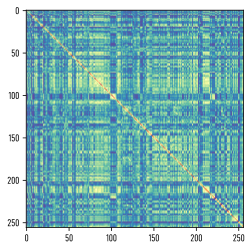

In [3]:
print(target.shape)
plt.imshow(target, cmap='Spectral')

In [4]:
batch_size = 1024
N, _ = target.shape

# GD, 1-10 components

## 10K steps

In [7]:
num_iters = 10000

for k in range(1, 11):
    fac = RBFExpansionPlus(
        k=k,
        batch_size=batch_size,
        max_steps=num_iters,
        lr=0.1
    )
    fac.fith(
        target,
        u0=1/10*torch.randn(batch_size, len(target), k),
        a0=torch.randn(batch_size, k),
        b0=torch.randn(batch_size)
    )
    fac.to_pickle(f'data/paper/GraphKernel.GD.ITER{num_iters}.BATCH{batch_size}.RANK{k}.pickle')
    plt.loglog(
        fac.report.loss_history_ticks,
        fac.report.loss_history.min(axis=1)
    )
    plt.loglog(
        fac.report.loss_history_ticks,
        np.minimum.accumulate(fac.report.loss_history.min(axis=1))
    )
    plt.title(f'{k} components')
    plt.show()

    error = fac.report.loss_best
    er = round(float(torch.min(error).cpu().detach().numpy()), 7)
    print(er)
    plt.imshow(fac.optimum(runs=torch.argmin(fac.report.loss_best)))
    plt.show()

SyntaxError: invalid syntax (<ipython-input-7-2f7ae4d986a5>, line 1)

# SGD, 1-10 components

## Run with 100K steps

100%|██████████| 100000/100000 [05:55<00:00, 281.13it/s]


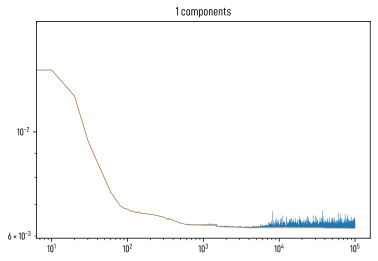

0.0062306


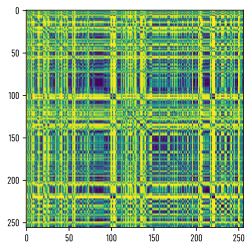

100%|██████████| 100000/100000 [06:20<00:00, 262.56it/s]


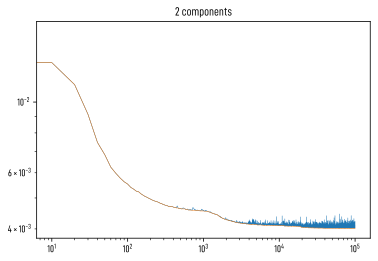

0.0040156


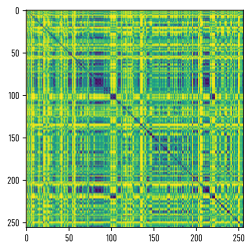

100%|██████████| 100000/100000 [07:03<00:00, 235.86it/s]


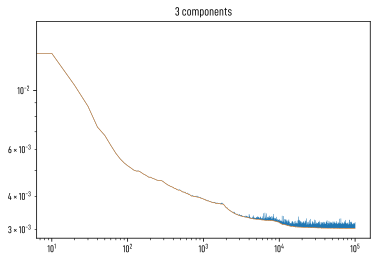

0.0030339


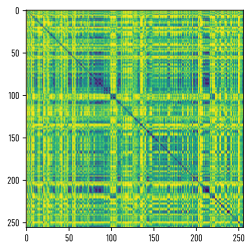

100%|██████████| 100000/100000 [08:08<00:00, 204.89it/s]


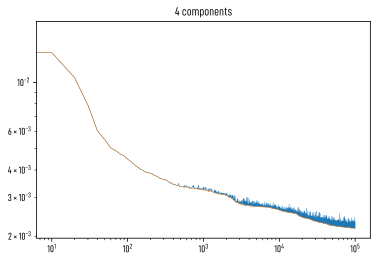

0.0021721


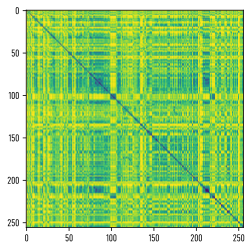

100%|██████████| 100000/100000 [08:58<00:00, 185.60it/s]


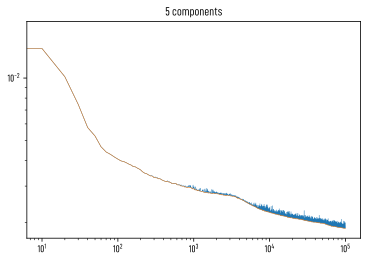

0.0018751


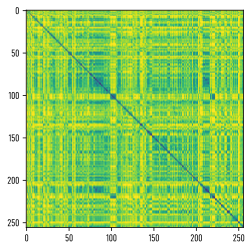

100%|██████████| 100000/100000 [09:46<00:00, 170.61it/s]


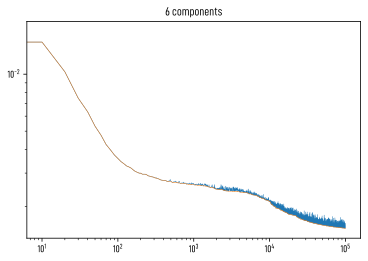

0.0015321


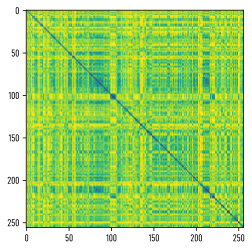

100%|██████████| 100000/100000 [10:33<00:00, 157.93it/s]


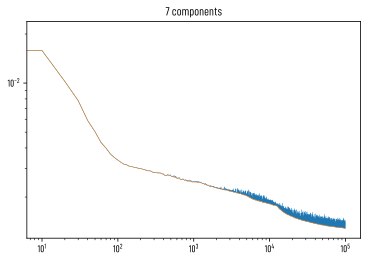

0.0012861


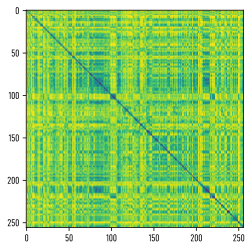

100%|██████████| 100000/100000 [11:49<00:00, 140.88it/s]


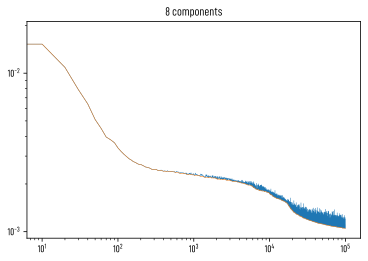

0.0010499


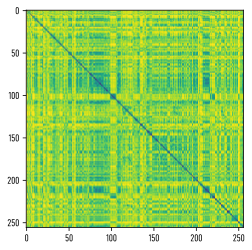

100%|██████████| 100000/100000 [12:44<00:00, 130.82it/s]


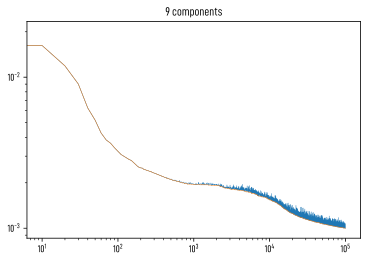

0.0009985


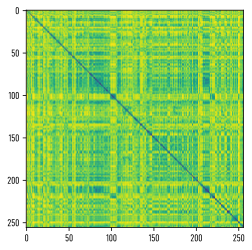

100%|██████████| 100000/100000 [13:32<00:00, 123.11it/s]


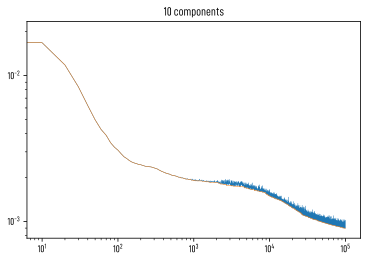

0.0008964


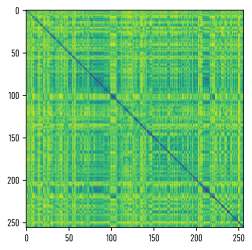

In [6]:
for k in range(1, 11):
    num_iters = 100000
    fac = RBFExpansionMiniBatchPlus(
        mini_batch_size=N * 8,
        k=k,
        batch_size=batch_size,
        max_steps=num_iters,
        lr=0.05
    )
    fac.fit_custom(
        target,
        f=lambda rbf, u, a, b:
            torch.sum(
                rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda rbf, i, j, u, a, b:
            torch.sum(
                rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        u=1/10*torch.randn(batch_size, len(target), k),
        a=torch.randn(batch_size, k),
        b=torch.randn(batch_size)
    )
    fac.to_pickle(f'data/paper/GraphKernel.SGD.ITER{num_iters}.BATCH{batch_size}.RANK{k}.MINIBATCH8.pickle')
    plt.loglog(
        fac.report.loss_history_ticks,
        fac.report.loss_history.min(axis=1)
    )
    plt.loglog(
        fac.report.loss_history_ticks,
        np.minimum.accumulate(fac.report.loss_history.min(axis=1))
    )
    plt.title(f'{k} components')
    plt.show()

    error = fac.report.loss_best
    er = round(float(torch.min(error).cpu().detach().numpy()), 7)
    print(er)
    plt.imshow(fac.optimum(runs=torch.argmin(fac.report.loss_best)))
    plt.show()

# SGD scan of power-of-two number of components

  0%|          | 0/100000 [00:00<?, ?it/s]/home/symfac/SymFac/venv-mpl3.4/lib64/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
100%|██████████| 100000/100000 [10:12<00:00, 163.25it/s]


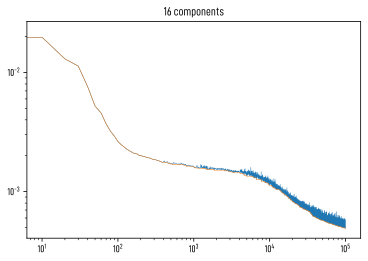

0.0004915


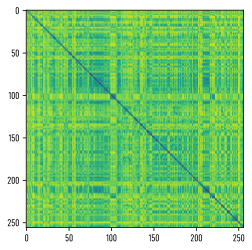

100%|██████████| 100000/100000 [09:20<00:00, 178.51it/s]


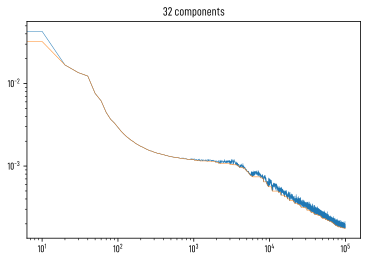

0.0001763


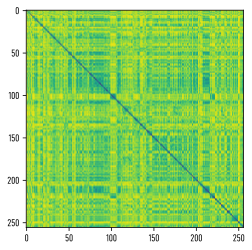

100%|██████████| 100000/100000 [08:34<00:00, 194.19it/s]


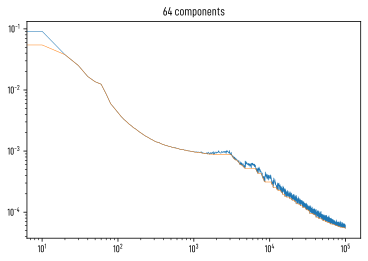

5.44e-05


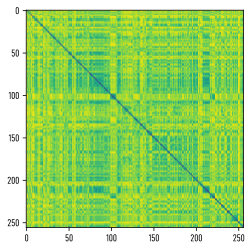

100%|██████████| 100000/100000 [08:13<00:00, 202.70it/s]


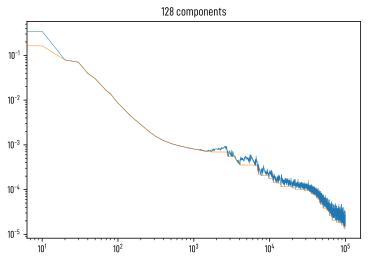

1.36e-05


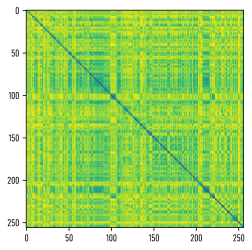

In [5]:
minibatch_multiplier = 8

for k in 2**np.arange(4, 8):
    num_iters = 100000
    
    batch_size_pow2 = 8192 // k  # reduce ensemble size to avoid OOM
    
    fac = RBFExpansionMiniBatchPlus(
        mini_batch_size=N * minibatch_multiplier,
        k=k,
        batch_size=batch_size_pow2,
        max_steps=num_iters,
        lr=0.05
    )
    fac.fit_custom(
        target,
        f=lambda rbf, u, a, b:
            torch.sum(
                rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda rbf, i, j, u, a, b:
            torch.sum(
                rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        u=1/10*torch.randn(batch_size_pow2, len(target), k),
        a=torch.randn(batch_size_pow2, k),
        b=torch.randn(batch_size_pow2)
    )
    fac.to_pickle(f'data/paper/GraphKernel.SGD.ITER{num_iters}.BATCH{batch_size_pow2}.RANK{k}.MINIBATCH{minibatch_multiplier}.pickle')
    plt.loglog(
        fac.report.loss_history_ticks,
        fac.report.loss_history.min(axis=1)
    )
    plt.loglog(
        fac.report.loss_history_ticks,
        np.minimum.accumulate(fac.report.loss_history.min(axis=1))
    )
    plt.title(f'{k} components')
    plt.show()

    error = fac.report.loss_best
    er = round(float(torch.min(error).cpu().detach().numpy()), 7)
    print(er)
    plt.imshow(fac.optimum(runs=torch.argmin(fac.report.loss_best)))
    plt.show()

# Sandbox below

  0%|          | 0/100000 [00:00<?, ?it/s]/home/symfac/SymFac/venv-mpl3.4/lib64/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
100%|██████████| 100000/100000 [14:47<00:00, 112.74it/s]


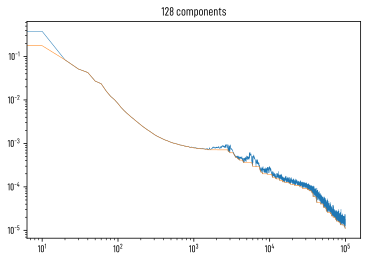

1.11e-05


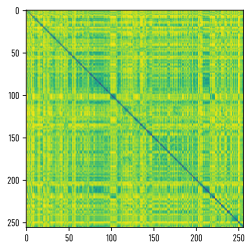

In [6]:
minibatch_multiplier = 8
batch_size_pow2 = 128  # reduce ensemble size to avoid OOM

for k in 2**np.arange(7, 8):
    num_iters = 100000
    fac = RBFExpansionMiniBatchPlus(
        mini_batch_size=N * minibatch_multiplier,
        k=k,
        batch_size=batch_size_pow2,
        max_steps=num_iters,
        # lr=0.1
    )
    fac.fit_custom(
        target,
        f=lambda rbf, u, a, b:
            torch.sum(
                rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda rbf, i, j, u, a, b:
            torch.sum(
                rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        u=1/10*torch.randn(batch_size_pow2, len(target), k),
        a=torch.randn(batch_size_pow2, k),
        b=torch.randn(batch_size_pow2)
    )
    # fac.to_pickle(f'data/paper/GraphKernel.SGD.ITER{num_iters}.BATCH{batch_size_pow2}.RANK{k}.MINIBATCH{minibatch_multiplier}.pickle')
    plt.loglog(
        fac.report.loss_history_ticks,
        fac.report.loss_history.min(axis=1)
    )
    plt.loglog(
        fac.report.loss_history_ticks,
        np.minimum.accumulate(fac.report.loss_history.min(axis=1))
    )
    plt.title(f'{k} components')
    plt.show()

    error = fac.report.loss_best
    er = round(float(torch.min(error).cpu().detach().numpy()), 7)
    print(er)
    plt.imshow(fac.optimum(runs=torch.argmin(fac.report.loss_best)))
    plt.show()

100%|██████████| 100000/100000 [14:46<00:00, 112.79it/s]


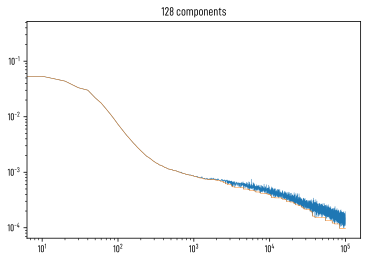

9.76e-05


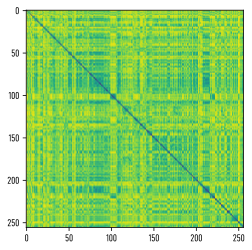

100%|██████████| 100000/100000 [14:50<00:00, 112.28it/s]


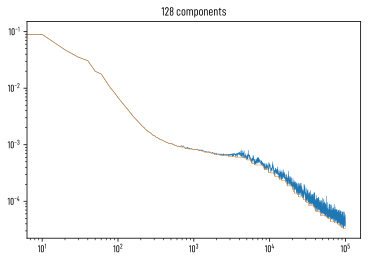

3.33e-05


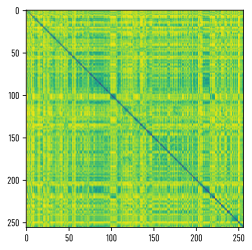

100%|██████████| 100000/100000 [14:49<00:00, 112.45it/s]


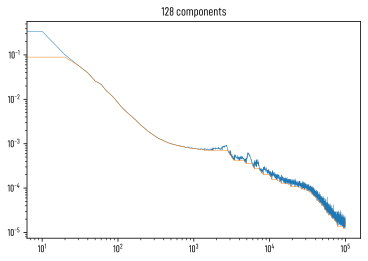

1.24e-05


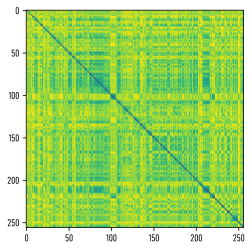

In [7]:
minibatch_multiplier = 8
batch_size_pow2 = 128  # reduce ensemble size to avoid OOM
num_iters = 100000
k = 128

for lr in [0.01, 0.02, 0.05]:
    fac = RBFExpansionMiniBatchPlus(
        mini_batch_size=N * minibatch_multiplier,
        k=k,
        batch_size=batch_size_pow2,
        max_steps=num_iters,
        lr=lr
    )
    fac.fit_custom(
        target,
        f=lambda rbf, u, a, b:
            torch.sum(
                rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda rbf, i, j, u, a, b:
            torch.sum(
                rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        u=1/10*torch.randn(batch_size_pow2, len(target), k),
        a=torch.randn(batch_size_pow2, k),
        b=torch.randn(batch_size_pow2)
    )
    # fac.to_pickle(f'data/paper/GraphKernel.SGD.ITER{num_iters}.BATCH{batch_size_pow2}.RANK{k}.MINIBATCH{minibatch_multiplier}.pickle')
    plt.loglog(
        fac.report.loss_history_ticks,
        fac.report.loss_history.min(axis=1)
    )
    plt.loglog(
        fac.report.loss_history_ticks,
        np.minimum.accumulate(fac.report.loss_history.min(axis=1))
    )
    plt.title(f'{k} components')
    plt.show()

    error = fac.report.loss_best
    er = round(float(torch.min(error).cpu().detach().numpy()), 7)
    print(er)
    plt.imshow(fac.optimum(runs=torch.argmin(fac.report.loss_best)))
    plt.show()